# Part 3: A Slightly More Complex Agent Based Model 

##### Authors: Bill Thompson (biltho@mpi.nl) and Limor Raviv (limor.raviv@mpi.nl) 
Please let us know if you have any comments, suggestions or questions regarding this notebook. 

---------------

## Summary
In this third tutorial, we will build a more complex simulation of agents using the commands in the second notebook, making our agents and their interactions a bit more ecologically valid. 

The major differences between these models are:
1. Instead of having agents with simple binary representaions (either [a] or [i]), agents in this model will have a distribution around their prefered vowel.
2. The interactions in this model will be double-sided, so that both agents change their behavior after interacting.
3. Agents' personalities will be less rigid, allowing for more intersting changes during interaction: stubborn agents will align a little bit (instead of not at all), while flexible agents will align to a greater extent (but not fully).

We will make multiple simulations of inertactions under different conditions, and see how this affects the distribution of vowels in the population. 


-------------- 


### 1. Setting up the network
First, let's create lists containing the possible biases for our agents. In this more complex model, agents have a range of possible vowels they can produce, which is distributed normally around a mean value on a single dimension. In this exmaple, a mean of "-1" will correspond to [a] and a mean of "1" will corresponf to [i].

In [1]:
# Set the model Parameters

vowel_means = [-1., 1.] # set possible inital means for the distributions

personalities = ['F', 'S']

In [2]:
# Create a function that makes a single agent based

def make_agent(vowel_mean, personality):
    return [vowel_mean, personality]


In [3]:
# Create a function that makes a population of random agents

import random

def make_population(N):
    
    population = []
    
    for i in range(N):
        
        m = random.randint(0,1)
        
        p = random.randint(0,1)
        
        agent = make_agent(vowel_means[m], personalities[p])
        
        population.append(agent)

    return population


# Check that this works by making a population of 8 agents
make_population(8)


[[1.0, 'F'],
 [-1.0, 'S'],
 [-1.0, 'S'],
 [1.0, 'S'],
 [1.0, 'S'],
 [1.0, 'S'],
 [-1.0, 'S'],
 [-1.0, 'S']]

### 2. Introducing more complex interations
So far, this looked similar to our simple model, but now it's time to introduce some new features.

Because we want our agents to have more complex representations, we also need to write a function that selects a specific vowel from the distribution implied by he agent's mean,  for each interaction.

In [4]:
# Create a function that chooses a variant from a distribution centered around the agent's mean vowel

from copy import deepcopy 
from numpy.random import normal

def choose_utterance(agent):   # sample from a normal distribution with SD=0.25 and mean of the teacher
    agent_utterance=normal(agent[0],.25)
    return agent_utterance

# Let's check that this works
# You can run this multiple times to see different chosen utternaces for different agents

pop=make_population(4)
vowel = choose_utterance(pop[0])
print "The agent's mean was", pop[0][0]
print "The agent's chosen utterance is", vowel

The agent's mean was -1.0
The agent's chosen utterance is -0.75793240804


In this new model, being flexible means that the agent shifts their vowel towards the other agents' utterance (by half of the distance between the mean and the utterance). This just means flexible agents adapt by going half way towrads the other agent. 

In addition, stubborn agents are not completey stubborn and are only adapting by a little bit (by 1/10 of the distance between their mean and the other agent's utterance).

Let's try to write this function using simple conditions:

In [6]:
# Create a function that shifts the means of a flexible agent

def shift_prior_flexible(utterance,mean):
    new_mean = (mean + utterance) / 2.
    return new_mean

    
# Create a function that shifts the means of a stubborn agent

def shift_prior_stubborn(utterance,mean): 
    difference = abs(utterance-mean)
    if utterance > mean:
        new_mean = mean + (difference/10.) 
        return new_mean
    else:
        new_mean = mean - (difference/10.)
        return new_mean

# Check that this works

stb_agent = shift_prior_stubborn(1,0)
flex_agent = shift_prior_flexible(1,0)

print stb_agent
print flex_agent

0.1
0.5


Now, we want both agents to update their representations after an interaction. This means that instead of having single-sided interactions with a listener and a producer, we now have an exchange of productions between the two agents in which each can learn from each other... 

For this, we'll write a new function called *"interact and learn"*, that updates the agents based on their current utterances and biased personalities:

In [7]:
# Create a function in which both agents generate utterances and can learn from each other 

def interact_and_learn((agent1,agent2)): 
    
    agent1_utterance = choose_utterance(agent1)
    
    agent2_utterance = choose_utterance(agent2)
    
    if agent1[0] == agent2[0]:
        pass # do nothing if the two agents have the same distributions 
    else:
        if agent1[1]=='S':
            agent1_new_mean = shift_prior_stubborn(agent2_utterance,agent1[0])
            agent1[0] = deepcopy(agent1_new_mean)
        else:
            agent1_new_mean = shift_prior_flexible(agent2_utterance,agent1[0])
            agent1[0] = deepcopy(agent1_new_mean)
        if agent2[1]=='S':
            agent2_new_mean = shift_prior_stubborn(agent1_utterance,agent2[0])
            agent2[0] = deepcopy(agent2_new_mean)
        else:
            agent2_new_mean = shift_prior_flexible(agent1_utterance,agent1[0])
            agent2[0] = deepcopy(agent2_new_mean)
    #return agent1_utterance, agent2_utterance, agent1, agent2
        

# Check if it works by uncommenting the "return" comment above 

interact_and_learn(([-1,'F'],[1,'S']))

### 3. Simulation time!
Great! Now we have a double-sided interaction, and we can write a function that chooses random pairs from a populations, and then simulate multiple interactions between different agents.

In [8]:
# Create a function that chooses two agents from a population
from numpy.random import choice

def choose_pair(population):
    i = random.randint(0, len(population) - 1) # phyton counts from 0, so pop(8) is an error
    j = random.randint(0, len(population) - 1)
    
    while i == j:
        j = random.randint(0, len(population) - 1)
        
    return population[i], population[j]

# Create a function that simulates k interactions in a population of n agents

def simulate(n, k):
    
    initial_population = make_population(n)
    population=deepcopy(initial_population)
    
    for i in range(k):
        
        pair = choose_pair(population)
        
        interact_and_learn(pair)
    
    return initial_population, population

Let's test that our simulation is working by looking at the results. Feel free to change the number of agents and the number of interactions as you please.

The initial population was [[1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [1.0, 'F'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'F'], [-1.0, 'F'], [-1.0, 'S'], [-1.0, 'F'], [1.0, 'S'], [-1.0, 'F'], [-1.0, 'S'], [1.0, 'S'], [-1.0, 'F'], [-1.0, 'F'], [1.0, 'S'], [-1.0, 'S'], [-1.0, 'F']]
The new population is [[0.43918061018526633, 'F'], [0.28742365672509046, 'F'], [0.4334948323040036, 'F'], [0.44223810799998287, 'F'], [0.6138812073253381, 'F'], [0.23234427452859133, 'S'], [0.3550877131245887, 'S'], [0.5495786807023015, 'F'], [0.7502717141340496, 'F'], [0.25941871539833405, 'S'], [0.20072731301702737, 'F'], [0.2590265448150829, 'S'], [0.5135589721153611, 'F'], [0.32030467328614376, 'S'], [0.2434032914595656, 'S'], [0.4645965114509586, 'F'], [0.25909097933208614, 'F'], [0.33924014523108603, 'S'], [0.2914168577580992, 'S'], [0.46372353626671037, 'F']]


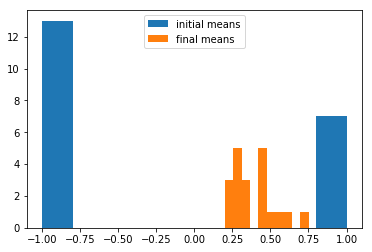

In [9]:
# Run a simulation with 8 agents and 5000 interactions

initial_population, new_population = simulate(20,5000)

print "The initial population was", initial_population
print "The new population is", new_population

# Plot the agents' initial and final means

%matplotlib inline 
# put plot in the notebook
import matplotlib.pyplot as plt # importing a plotting library

initial_means = []
final_means = []

for agent in range(len(initial_population)):
    initial_means.append(initial_population[agent][0])
    final_means.append(new_population[agent][0])  


plt.hist(initial_means, label='initial means')
plt.hist(final_means, label='final means')
plt.legend(loc='upper center')
plt.show()  

In the plot above, the clustering of organge agents (final population) shows convergence, while the spread distribution (blue, initial population) implies divergence.

In most simulations, you'll see convergence.

But since as you've seen, each simulation yields different outcomes in terms of which variant agents have converged on, we need to run multiple simulations and compute their mean to get a more reliable picture of what's happening. So let's make a function that computes the final means of several simulations.

In [10]:
# Create a function to compute the means of the vowels in the population

def compute_mean(population):
    t=0.
    for agent in population:
        t += agent[0]
    return t/len(population)

# Create a function that runs multiuple simulations and returns the final mean of each of them

def batch_simulate(n,k,s): #n=pop size, k=no. of interactions, s=no. of simulations
    batch_final=[]
    for i in range(s):
        initial_population, new_population = simulate(n, k)
        new_proportion=compute_mean(new_population)
        batch_final.append(new_proportion)
    return batch_final
        

So what's going on? Let's run some simulations! This might take a few minutes to complete.

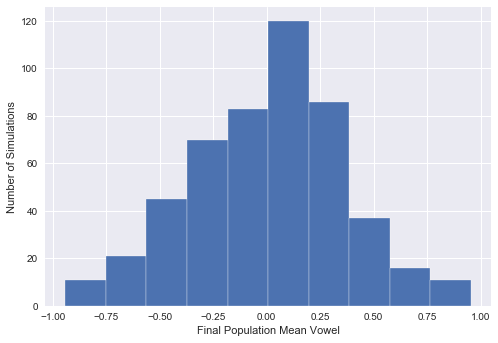

In [13]:
# Run 500 simulations
results = batch_simulate(20,5000,500)

# Plot the result
import seaborn as sns # make the plot look better
plt.hist(results, edgecolor = 'white')
plt.xlabel('Final Population Mean Vowel')
plt.ylabel('Number of Simulations')

What you can see in the historgram above is that in most simulations, the population converges on the mean between the two initial variants (which is 0). This result is exactly what we expect given prior studies with similar models.

## Wrapping up
So you did it! You finished the tutorial and made a model with more complex agents and complex interactions. 

Hopefully, now you feel confident enough to change different parts of the code, or add your own new features. 

Good luck with your model!

Bill & Limor